In [1]:
import numpy as np
import scipy.constants as c
import matplotlib.pyplot as plt
%matplotlib inline
import util
import axion_mass as m_a
import config
model = config.Model()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.ticker

In [2]:
m_a.m_a_at_abs_zero_from_marsh(1.0), m_a.m_a_at_abs_zero_from_shellard(1.0)

(6000000000000000.0, 5806498440492653.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


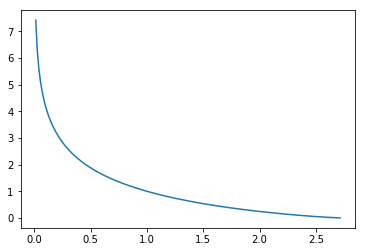

In [3]:
Lambda_over_T = np.linspace(0, 4, 300)
plt.plot(Lambda_over_T, (1 - np.log(Lambda_over_T))**1.2)

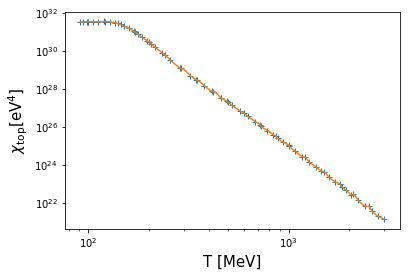

In [6]:
plt.loglog(m_a.T_data / 1e6, m_a.chi_data, "+")
T = np.linspace(m_a.T_data[0], m_a.T_data[-1], 300)
plt.loglog(T / 1e6, m_a.chi_interp(T))

plt.xlabel("T [MeV]", fontsize=15)
plt.ylabel(r"$\chi_\mathrm{top} [\mathrm{eV}^4]$", fontsize=15)
plt.savefig("Plots/chi_of_T.pdf")

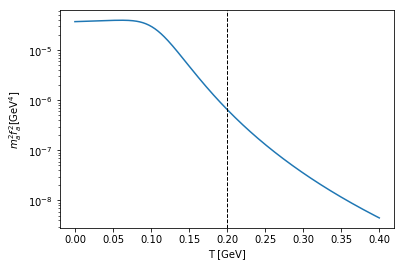

In [7]:
T = np.linspace(0, 400e6, 400)
Lambda = 400e6
m_a_f_a_sq = 1.46e-3 * Lambda**4 * (1 + 0.5*T/Lambda) / (1 + (3.53*T/Lambda)**7.48)
plt.semilogy(T / 1e9, m_a_f_a_sq / 1e9**4)
plt.xlabel("T [GeV]")
plt.ylabel(r"$m_a^2 f_a^2 [\mathrm{GeV}^4]$")
plt.axvline(0.2, color="black", lw=1, linestyle="--")

In [12]:
import importlib
m_a = importlib.reload(m_a)
import itertools

def set_ticks_fontsize(fontsize):
    ax = plt.gca()
    for tick in itertools.chain(ax.xaxis.get_major_ticks(), ax.yaxis.get_minor_ticks(), ax.yaxis.get_major_ticks(), ax.yaxis.get_minor_ticks()):
        tick.label.set_fontsize(fontsize)

fontsize = 17
linewidth = 3

def make_comparsion_plot(T_min=10**7.8, T_max=None):
    # general constants
    f_a = 1e14 * 1e9
    
    if T_max is None:
        T_max = np.max(m_a.T_data)
    T = np.logspace(np.log10(T_min), np.log10(T_max), 400)

    plt.figure(figsize=(18, 6))
    ######################### plot the graph of m_a(T) ########################
    plt.subplot(1, 2, 1)
    
    ## T = 0
    plt.loglog(T / 1e6, m_a.m_a_at_abs_zero_from_shellard(f_a) * np.ones(np.size(T)),
            label=r"$m_a(T = 0)$ Shellard", linestyle="-.", color="lightskyblue", linewidth=linewidth)

    ## low T from shellard 
    shellard_low_T_range = T < m_a.T3 
    plt.loglog(T[shellard_low_T_range] / 1e6, m_a.m_a_at_low_T_from_shellard(T, f_a)[shellard_low_T_range], 
               linestyle="-.", color="red", label="Shellard low T", linewidth=linewidth)

    ## T > Lambda_QCD 
    # fox for high T > Lambda_QCD
    fox_ma = m_a.m_a_at_high_T_from_fox(T, f_a, False)
    is_smaller_than_m0 = fox_ma < m_a.m_a_at_abs_zero_from_shellard(f_a)
    plt.loglog(T[is_smaller_than_m0] / 1e6, fox_ma[is_smaller_than_m0], "--", label="Fox", color="blue", linewidth=linewidth)
    is_larger_than_Lambda_QCD = T > model.Lambda_QCD
    plt.loglog(T[is_larger_than_Lambda_QCD] / 1e6, m_a.m_a_at_high_T_from_fox(T, f_a, True)[is_larger_than_Lambda_QCD], "--", label="Fox corr", color="orange", linewidth=linewidth)

    # shellard for high T
    # plt.loglog(T / 1e6, m_a.m_a_at_high_T_from_shellard(T, f_a), label="Shellard", linestyle="-.", color="darkviolet", linewidth=linewidth)
    
    # shellard IILA
    plt.loglog(T / 1e6, m_a.m_a_full_IILA_shellard(T, f_a), label="Shellard IILA", linestyle="-", color="green", linewidth=linewidth)

    ## general lattice result
    plt.loglog(T / 1e6, m_a.m_a_from_chi(T, f_a),
            label=r"Borsanyi Lattice $\chi_\mathrm{top}$", linestyle=":", color="black", linewidth=linewidth)

    ## add plot label etc. 
    plt.axvline(model.Lambda_QCD / 1e6, linestyle="-", color="black")
    plt.ylabel(r"$m_a(T) [\mathrm{eV}]$", fontsize=15)
    plt.grid()
    
    #ax = plt.gca()
    #ax.set_xticks([])
    #plt.minorticks_off()
    
    ax = plt.gca()
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xticks([100, 200, 400, 1000, 2000], ["100", r"$\Lambda_\mathrm{QCD}$", "400", "1000", "2000"])
    plt.minorticks_off()
    plt.xlabel(r"$T [MeV]$", fontsize=15)
    plt.xlim(T_min / 1e6, T_max / 1e6)
    # plt.legend(loc="lower left", ncol=2, fontsize=12)
    plt.legend(ncol=2, fontsize=15)
    set_ticks_fontsize(fontsize)

    ################# error from lattice result #################
    plt.subplot(1, 2, 2)
    
    m_a_correct =  m_a.m_a_from_chi(T, f_a)
    def rel_err(m_a_approx_fn, *args, **kwargs):
        return np.abs(m_a_approx_fn(T, f_a, *args, **kwargs) - m_a_correct) / m_a_correct
    
    # T = 0
    plt.loglog(T / 1e6, rel_err(lambda T, f_a: m_a.m_a_at_abs_zero_from_shellard(f_a) * np.ones(T.size)), 
               linestyle="-.", color="lightskyblue", linewidth=linewidth)
    
    # T < Lambda_QCD
    # shellard
    plt.loglog(T[shellard_low_T_range] / 1e6, rel_err(m_a.m_a_at_low_T_from_shellard)[shellard_low_T_range], linestyle="-.", color="red", linewidth=linewidth)
    
    # T > Lambda_QCD
    # shellard
    # plt.loglog(T / 1e6, rel_err(m_a.m_a_at_high_T_from_shellard), linestyle="-.", color="darkviolet", linewidth=linewidth)
    
    # shellard IILA
    plt.loglog(T / 1e6, rel_err(m_a.m_a_full_IILA_shellard), linestyle="-", color="green", linewidth=linewidth)

    # fox
    plt.loglog(T[is_smaller_than_m0] / 1e6, rel_err(m_a.m_a_at_high_T_from_fox, False)[is_smaller_than_m0], "--", color="blue", linewidth=linewidth)
    plt.loglog(T[is_larger_than_Lambda_QCD] / 1e6, rel_err(m_a.m_a_at_high_T_from_fox, True)[is_larger_than_Lambda_QCD],  "--", color="orange", linewidth=linewidth)
    
    # add stuff
    ax = plt.gca()
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xticks([100, 200, 400, 1000, 2000], ["100", r"$\Lambda_\mathrm{QCD}$", "400", "1000", "2000"])
    plt.minorticks_off()
    plt.xlabel(r"$T [MeV]$", fontsize=15)
    
    plt.ylabel("relative error to full lattice result", fontsize=15)
    plt.grid()
    plt.axvline(model.Lambda_QCD / 1e6, linestyle="-", color="black")
    plt.xlim(T_min / 1e6, T_max / 1e6)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, 10)
    set_ticks_fontsize(fontsize)
    plt.tight_layout()

/home/janik/Documents/bachelor/axion_mass.py:168: RuntimeWarning: invalid value encountered in power
  correction_factor = (1 - np.log(model.Lambda_QCD / T))**d
/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


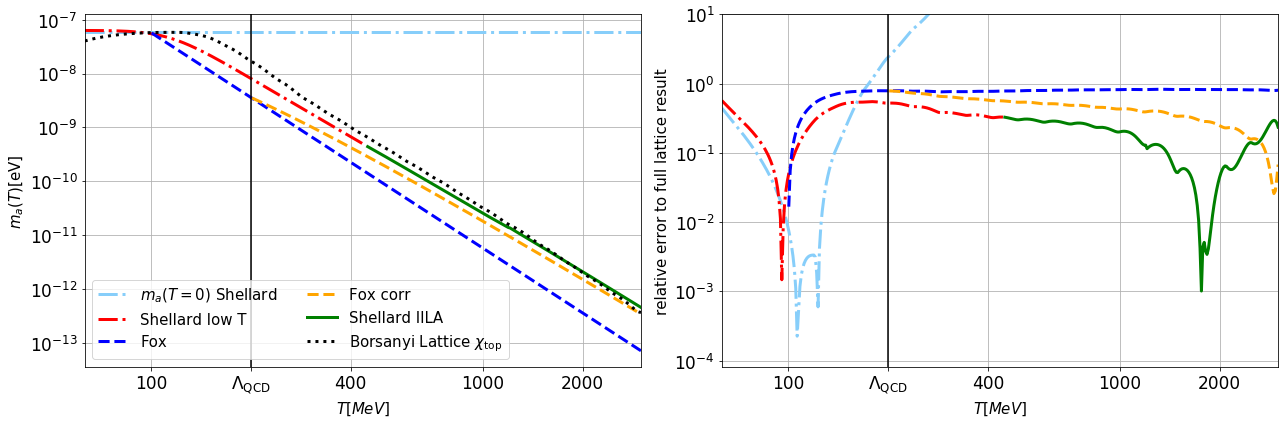

In [13]:
make_comparsion_plot()
plt.savefig("Plots/m_of_T_plot.pdf")

/usr/local/lib/python3.6/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


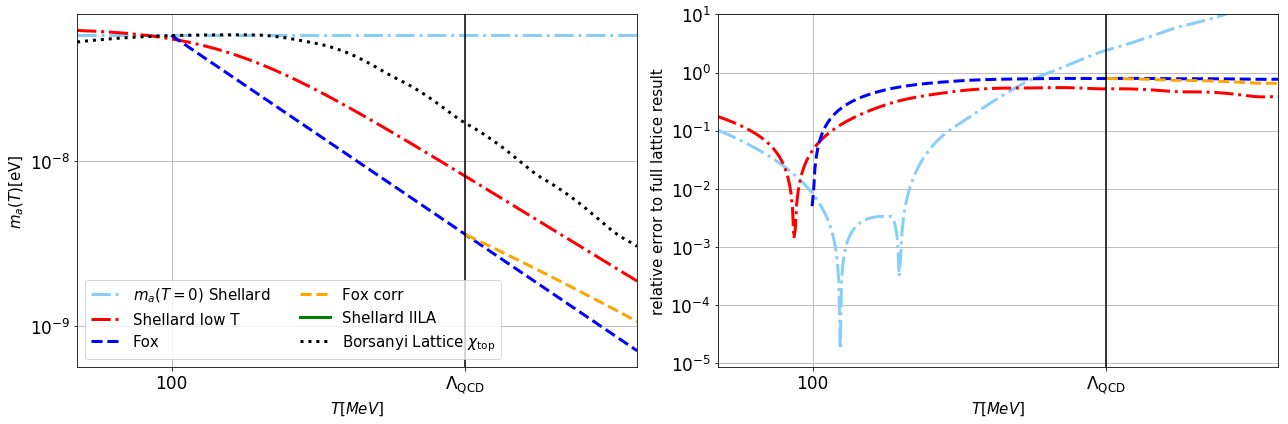

In [14]:
make_comparsion_plot(80e6, 300e6)

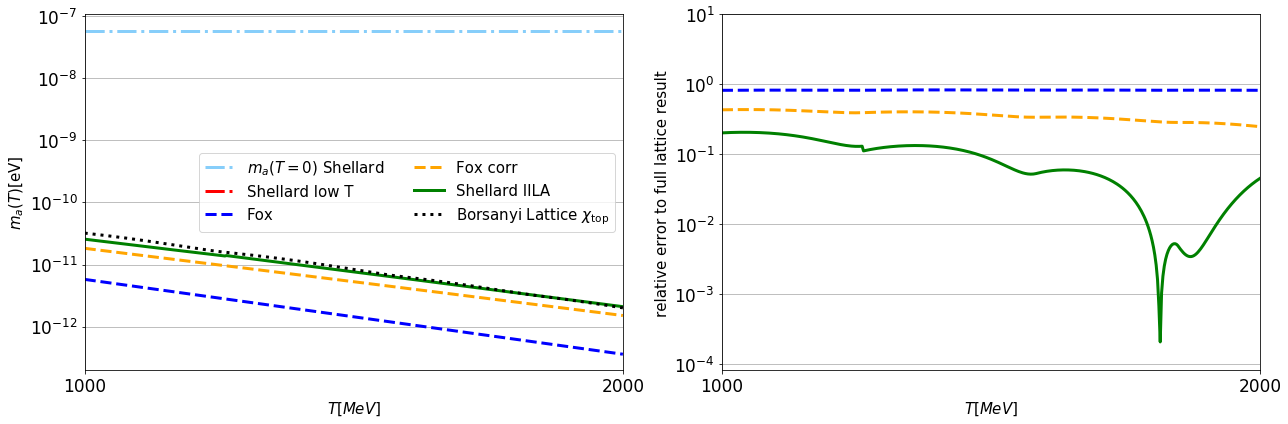

In [15]:
make_comparsion_plot(1000e6, 2000e6)

In [ ]:
plt.ylim?